setup/ import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbCallback, WandbModelCheckpoint

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

In [2]:
print('Tensorflow version:', tf.__version__)
print('Weights and biases version:', wandb.__version__)

Tensorflow version: 2.19.0
Weights and biases version: 0.21.1


load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X_train = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/reduced datasets/train_aug_images_160x320_25.npy')
X_val = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/val_images_160x320.npy')
X_test = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_images_160x320.npy')

y_train = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/reduced datasets/train_aug_landmarks_25.npy')
y_val = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/val_landmarks.npy')
y_test = np.load('/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/test_landmarks.npy')

In [5]:
print(X_train.shape)
print(y_train.shape)

(740, 160, 320, 3)
(740, 18, 2)


define hyperparameters

In [7]:
def get_config(model_name='CNN_withIphone_100_augmentation_25_dataset',
               img_size=(160, 320),
               batch_size=16,
               learning_rate_transfer=1e-3,
               learning_rate_tuning=5e-4,
               max_epochs_transfer=50,
               max_epochs_tuning=100,
               early_stop_patience=10,
               steps_per_epoch=81,
               dropout=0.5,
               seed=42):

    # cosine decay
    cosine_decay_steps = steps_per_epoch * max_epochs_tuning
    learning_schedule = {
        'initial_learning_rate': learning_rate_tuning,
        'decay_steps': cosine_decay_steps,
        'warmup_target': learning_rate_tuning,
        'warmup_steps': int(cosine_decay_steps * 0.02)
    }

    # config dictionary
    config = {
        'model_name': model_name,
        'img_size': img_size,
        'batch_size': batch_size,
        'learning_rate_transfer': learning_rate_transfer,
        'learning_rate_tuning': learning_rate_tuning,
        'max_epochs_transfer': max_epochs_transfer,
        'max_epochs_tuning': max_epochs_tuning,
        'early_stop_patience': early_stop_patience,
        'steps_per_epoch': steps_per_epoch,
        'cosine_decay_steps': cosine_decay_steps,
        'dropout': dropout,
        'learning_schedule': learning_schedule,
        'seed': seed
    }

    return config

In [8]:
config = get_config()
SEED = config['seed']
img_size = config['img_size']
batch_size = config['batch_size']
seed = config['seed']

create tensorflow dataset

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

define loss and metric

In [10]:
# loss in normalized units [0,1]
# computes mean squared error per landmark in normalized coordinates
# arg: y_true and y_pred in tensor shape (batch_size, num_landmarks, 2) [0,1]
# returns scalar tensor: average MSE over all landmarks in the batch
def landmark_mse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1))


# metric
# mean pixel error
# computes average euclidean distance per landmark in pixels
# arg: y_true and y_pred in tensor shape (batch_size, num_landmarks, 2) [0,1]
#      img_size: tuple [int, int], image height and with (H, W)
# returns scalar tensor: mean pixel error over batch
def mean_pixel_error_metric_160_320(y_true, y_pred):
    H, W = 160,320
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_px = y_true * tf.constant([W, H], dtype=tf.float32)
    y_pred_px = y_pred * tf.constant([W, H], dtype=tf.float32)
    dist = tf.sqrt(tf.reduce_sum(tf.square(y_true_px - y_pred_px), axis=-1))
    return tf.reduce_mean(dist)

define model

In [11]:
from tensorflow.keras.applications import ResNet50

def build_resnet50_landmark_model(input_shape=(160, 320, 3),
                                  num_landmarks=18,
                                  trainable_backbone=False):
    backbone = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )
    backbone.trainable = trainable_backbone

    inputs = tf.keras.Input(shape=input_shape)
    x = backbone(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # head
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # output
    x = tf.keras.layers.Dense(num_landmarks * 2, activation='sigmoid')(x)
    outputs = tf.keras.layers.Reshape((num_landmarks, 2))(x)

    return tf.keras.Model(inputs, outputs, name='resnet50_landmark_model')

In [12]:
input_shape = (160, 320, 3)
num_landmarks = 18

model = build_resnet50_landmark_model(input_shape=input_shape, num_landmarks=num_landmarks)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate_transfer']),
              loss=landmark_mse,
              metrics=[mean_pixel_error_metric_160_320])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50_landmark_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 10, 2048)    │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 18, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,149,796 (92.12 MB)

 Trainable params: 562,084 (2.14 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

callbacks // weights and biases

In [13]:
wandb.init(project='mosquito_landmarks',name=f"{config['model_name']}",config=config)

callbacks = [EarlyStopping(monitor='val_loss',
            patience=config['early_stop_patience'],
            restore_best_weights=True,
            verbose=1),
            WandbMetricsLogger(),
            WandbModelCheckpoint("wandb_model.keras")]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arlettedel (arlettedel-universit-t-hamburg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


train model

In [14]:
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=config['max_epochs_transfer'],
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 414ms/step - loss: 0.1092 - mean_pixel_error_metric_160_320: 84.3890 - val_loss: 0.0851 - val_mean_pixel_error_metric_160_320: 77.7563
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.0868 - mean_pixel_error_metric_160_320: 78.2616 - val_loss: 0.0844 - val_mean_pixel_error_metric_160_320: 77.8593
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.0850 - mean_pixel_error_metric_160_320: 77.5061 - val_loss: 0.0780 - val_mean_pixel_error_metric_160_320: 74.4487
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.0835 - mean_pixel_error_metric_160_320: 76.4407 - val_loss: 0.0776 - val_mean_pixel_error_metric_160_320: 74.3214
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.0815 - mean_pixel_error_metric_160_320: 75.4238 - val_loss: 0.0700 - val_mean_pixel_error_metric_160_320: 69.7744
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.0745 - mean_pixel_error_metric_160_320: 70.8024 - val_los

fine tuning

In [15]:
# unfreeze layer for fine tuning
for layer in model.layers:
    layer.trainable = True

# new optimizer for fine tuning
optimizer = tf.keras.optimizers.Adam(
    learning_rate=config['learning_rate_tuning'])

model.compile(optimizer=optimizer, loss=landmark_mse)

# callback fine tuning
callbacks_ft = [
    EarlyStopping(
        monitor='val_loss',
        patience=config['early_stop_patience'],
        restore_best_weights=True,
        verbose=1),
    WandbMetricsLogger(),
    WandbModelCheckpoint("wandb_model_finetuned.keras")]

# wandb
wandb.init(
    project='mosquito_landmarks',
    name=f"{config['model_name']}_finetune",
    config=config,
    reinit=True)  # important for new run

# fine tuning
history_ft = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config['max_epochs_tuning'],
    callbacks=callbacks_ft,
    verbose=1)

epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▇▆▅▅▄▃▃▄▃▂▂▂▁▁▂▂▂▂▁▁▁▂▂▁▁▁▃▄▄▃
epoch/mean_pixel_error_metric_160_320,███▇▇▇▆▅▄▄▃▄▃▂▂▂▁▁▂▂▂▁▁▁▁▂▁▁▁▁▂▄▄▃
epoch/val_loss,██▇▇▇▆▅▄▃▃▃▃▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▆▂▂▂
epoch/val_mean_pixel_error_metric_160_320,████▇▇▅▅▄▃▃▄▄▂▂▂▁▁▂▃▂▁▁▁▂▂▂▂▂▂▆▃▃▃
epoch/epoch,33
epoch/learning_rate,0.001
epoch/loss,0.04422
epoch/mean_pixel_error_metric_160_320,44.31318
epoch/val_loss,0.01522


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 94s 891ms/step - loss: 0.1295 - mean_pixel_error_metric_160_320: 77.2337 - val_loss: 0.1169 - val_mean_pixel_error_metric_160_320: 85.7145
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - loss: 0.0115 - mean_pixel_error_metric_160_320: 23.0984 - val_loss: 0.0791 - val_mean_pixel_error_metric_160_320: 73.4696
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - loss: 0.0061 - mean_pixel_error_metric_160_320: 17.4312 - val_loss: 0.0946 - val_mean_pixel_error_metric_160_320: 68.5933
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - loss: 0.0051 - mean_pixel_error_metric_160_320: 15.9418 - val_loss: 0.0991 - val_mean_pixel_error_metric_160_320: 68.0028
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - loss: 0.0039 - mean_pixel_error_metric_160_320: 13.7248 - val_loss: 0.1495 - val_mean_pixel_error_metric_160_320: 73.8506
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - loss: 0.0038 - mean_pixel_error_metric_160_320: 13.190

plot loss for train and evaluation

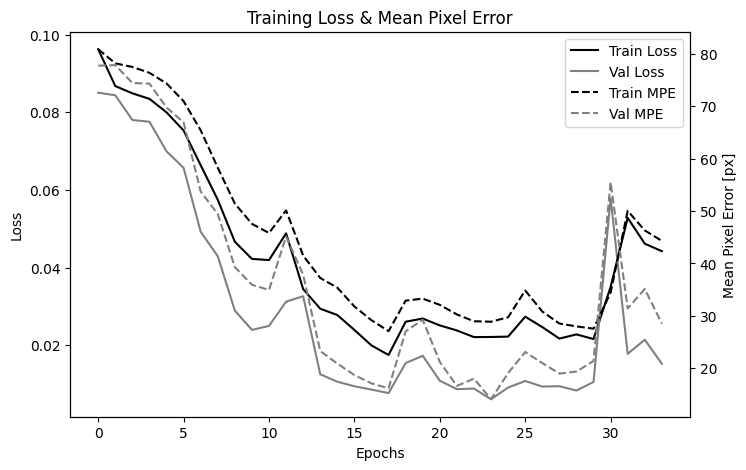

In [16]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# y1: loss
ax1.plot(history.history['loss'], label='Train Loss', linestyle='-', color='black')
ax1.plot(history.history['val_loss'], label='Val Loss', linestyle='-', color='gray')
ax1.set_xlabel('Epochs', color='black')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.tick_params(axis='x', labelcolor='black')

# y2: MPE
ax2 = ax1.twinx()
ax2.plot(history.history['mean_pixel_error_metric_160_320'], label='Train MPE', linestyle='--', color='black')
ax2.plot(history.history['val_mean_pixel_error_metric_160_320'], label='Val MPE', linestyle='--', color='gray')
ax2.set_ylabel('Mean Pixel Error [px]', color='black')
ax2.tick_params(axis='y', labelcolor='black')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Training Loss & Mean Pixel Error", color='black')
plt.show()

mini evaluation test set

In [17]:
#mpe +- std
pred_coords_norm = model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step


In [18]:
distances = np.linalg.norm(y_test - pred_coords_norm, axis=-1)

In [19]:
# image size
H, W = 160, 320

# convert to pixel size
diff_pixel = (y_test - pred_coords_norm) * np.array([H, W])
distances_pixel = np.linalg.norm(diff_pixel, axis=-1)

# prediction errors
mpe_mean = distances_pixel.mean()
mpe_std = distances_pixel.std()
mpe_median = np.median(distances_pixel)

print(f"Mean Prediction Error (MPE) in pixels: {mpe_mean:.2f} ± {mpe_std:.2f}")
print(f"Median Prediction Error in pixels: {mpe_median:.2f}")

Mean Prediction Error (MPE) in pixels: 7.68 ± 5.94
Median Prediction Error in pixels: 6.34


save predictions in normalized pixel coords for evaluation

In [20]:
save_dir2 = '/content/drive/MyDrive/Arlette/Model_Outputs'
os.makedirs(save_dir2, exist_ok=True)
np.save(f"{save_dir2}/predictions_norm_CNN_full_augmentation_25.npy", pred_coords_norm)

save model weights and output

In [21]:
#save best config based on validation loss

In [22]:
save_dir = '/content/drive/MyDrive/Arlette/model_weights'
os.makedirs(save_dir, exist_ok=True)

model.save(f'{save_dir}/CNN_full_augmentation_25.keras')
model.save_weights(f'{save_dir}/CNN_full_augmentation_25.weights.h5')